# iCAT Preprocess
---
Overview and interactive walkthrough of how to configure Odemis tile data for use in `render-ws`.

Annoyingly, ...

Assumes that high magnification EM tiles are stored by themselves, while all FM channels are together with the low magnification EM channel in a multi-page tiff.

Starting config
```
project
    ├───┬ lil_EM
    │   ├──── tile-00000x00000.ome.tiff
    │   ├──── tile-00000x00001.ome.tiff
    │   ├──── ...
    │   ├──── tile-00022x00025.ome.tiff
    │   └──── tile-00022x00026.ome.tiff
    ├──── big_tile-00000x00000.ome.tiff
    ├──── big_tile-00000x00001.ome.tiff
    ├──── ...
    ├──── big_tile-00002x00001.ome.tiff
    └──── big_tile-00002x00002.ome.tiff

```

Desired config
```
project
    ├───┬ amylase
    │   └─── amylase-00000x00000.ome.tif
    ├───┬ big_EM
    │   └──── big_EM-00000x00000.ome.tif
    ├───┬ hoechst
    │   └──── hoechst-00000x00000.ome.tif
    ├───┬ insulin
    │   └──── insulin-00000x00000.ome.tif
    └───┬ lil_EM
        ├──── lil_EM-00008x00011.ome.tif
        ├──── lil_EM-00008x00012.ome.tif
        ├──── ...
        ├──── lil_EM-00012x00015.ome.tif
        └──── lil_EM-00012x00016.ome.tif
```

#### Notes
* Only tested on `ome.tiff` file type.

## 1 Reconfigure Image Tiles
### 1.0 Imports

In [138]:
from pathlib import Path
import numpy as np
import re
from bs4 import BeautifulSoup as Soup

from skimage.external.tifffile import TiffFile, TiffWriter
from skimage.io import imread

import matplotlib.pyplot as plt
%matplotlib inline

In [135]:
odemis_path = Path('/long_term_storage/rlane/SECOM/pancrea_20180429_odemis/')

project_path = Path('/long_term_storage/rlane/SECOM/pancrea_20180429/')
project_path.mkdir(parents=True, exist_ok=True)

### 1.1 Handle Single-channel Data
This is assumed to be the high magnification EM tiles. All we have to do is rename the tiles such that they go by the convention  
`.../<project>/<stack>/<stack>-<col>x<row>.ome.tif`

In [127]:
# Target names
stack = 'lil_EM'
tile = 'lil_EM'
ext = 'ome.tif'

# Gather all high mag EM tiles
tile_fns = (odemis_path / odemis_stack).glob('*.ome.tiff')

# Rename and move to project directory
# Check before uncommenting
for tile_fn in tile_fns:
    # Set target path
    target_parent = project_path / target_names['stack']
    target_parent.mkdir(parents=True, exist_ok=True)
    col, row = re.findall('\d+', tile_fn.name)
    target_name = f'{tile}-{col}x{row}.{ext}'
    # Rename
    # tile_fn.rename(target_parent / target_name)
    print(target_parent / target_name)

### 1.2 Handle Multi-channel Data
This is assumed to be all the FM tiles (all channels) plus the low magnification EM tiles. This is much harder. Not only do we have to rename the tiles in the same way we just did for the high mag EM tiles, but we also have to separate the channels, extract the metadata, and substitute the metadata back into each of the channels.

#### Determine channels within multi-channel data
Not really sure of a good way to do this autonomously if the page name is the usual `Filtered colour #`. Probably best to open an image in the viewer and go off that.

In [201]:
multi_channel_fns = odemis_data_path.glob('big_FM*')

tif = TiffFile(list(multi_channel_fns)[0].as_posix())
print(f'TIFF path: {odemis_data_path}')
print(tif)

for page in tif.pages:
    print(page.tags['page_name'].value)

TIFF path: /long_term_storage/rlane/SECOM/pancrea_20180429_odemis
TIFF file: big_FM-00000x00000.ome.tiff, 20 MiB, little endian, ome, 3 pages, 3 series
b'Filtered colour 1'
b'Filtered colour 3'
b'Filtered colour 2'


In [202]:
channel_map = {b'Filtered colour 1': 'hoechst',
                b'Filtered colour 2': 'amylase',
                b'Filtered colour 3': 'insulin',
                b'Secondary electrons': 'big_EM'
}

#### Split tiffs by channel and save them separately

In [203]:
# Have to regenerate list of multi-channel image tiles
multi_channel_fns = odemis_data_path.glob('big_FM*')

# Loop through multi-channel image tiles
for fn in multi_channel_fns:
    tif = TiffFile(fn.as_posix())
    page_0 = tif.pages[0]
    for page in tif.pages:
        
        # Map Odemis channel to target channel
        odemis_channel = page.tags['page_name'].value
        channel = channel_map[odemis_channel]
        
        # Set target path
        target_parent = project_path / channel
        target_parent.mkdir(parents=True, exist_ok=True)
        col, row = re.findall('\d+', fn.name)
        target_name = f'{channel}-{col}x{row}.{ext}'
        target = target_parent / target_name
        
        # Save each channel as tiff with ome metadata
        print(f'Saving {target}')
        with TiffWriter(target.as_posix()) as out:
            # Unable to remove annoying 'image_description_1' tag unfortunately
            out.save(page.asarray(), description=page_0.tags['image_description'].value)

Saving /long_term_storage/rlane/SECOM/pancrea_20180429/hoechst/hoechst-00000x00000.ome.tif
Saving /long_term_storage/rlane/SECOM/pancrea_20180429/insulin/insulin-00000x00000.ome.tif
Saving /long_term_storage/rlane/SECOM/pancrea_20180429/amylase/amylase-00000x00000.ome.tif
Saving /long_term_storage/rlane/SECOM/pancrea_20180429/hoechst/hoechst-00000x00001.ome.tif
Saving /long_term_storage/rlane/SECOM/pancrea_20180429/insulin/insulin-00000x00001.ome.tif
Saving /long_term_storage/rlane/SECOM/pancrea_20180429/amylase/amylase-00000x00001.ome.tif
Saving /long_term_storage/rlane/SECOM/pancrea_20180429/hoechst/hoechst-00001x00000.ome.tif
Saving /long_term_storage/rlane/SECOM/pancrea_20180429/insulin/insulin-00001x00000.ome.tif
Saving /long_term_storage/rlane/SECOM/pancrea_20180429/amylase/amylase-00001x00000.ome.tif
Saving /long_term_storage/rlane/SECOM/pancrea_20180429/hoechst/hoechst-00001x00001.ome.tif
Saving /long_term_storage/rlane/SECOM/pancrea_20180429/insulin/insulin-00001x00001.ome.tif

## 2 Check Reconfigured TIFFs

In [204]:
# Collect one newly created tiff from each stack
sample_tile_fns = dict.fromkeys(channel_map.values())
for stack in sample_tile_fns:
    sample_tile_fns[stack] = list((project_path/stack).glob('*'))[0]

# Ensure each tiff has only 1 page
for stack, tile_fn in sample_tile_fns.items():
    tif = TiffFile(tile_fn.as_posix())
    if not len(tif.pages) == 1:
        if len(tif.pages) > 1:
            raise ValueError("Tiff has more than 1 page")
        else:
            raise ValueError("Tiff has no pages")

#### Gather metadata

In [205]:
# Gather metadata
sample_metadata = {}
for stack, tile_fn in sample_tile_fns.items():
    tif = TiffFile(tile_fn.as_posix())
    page = tif.pages[0]
    xml = page.tags['image_description'].value
    sample_metadata[stack] = Soup(xml, 'lxml')

In [206]:
print(sample_metadata['insulin'].prettify())

<?xml version="1.0" encoding="UTF-8"?>
<html>
 <body>
  <ome xmlns="http://www.openmicroscopy.org/Schemas/OME/2012-06" xmlns:xsi="http://www.w3.org/2001/XMLSchema-instance" xsi:schemalocation="http://www.openmicroscopy.org/Schemas/OME/2012-06 http://www.openmicroscopy.org/Schemas/OME/2012-06/ome.xsd">
   <!--Warning: this comment is an OME-XML metadata block, which contains crucial dimensional parameters and other important metadata. Please edit cautiously (if at all), and back up the original data before doing so. For more information, see the OME-TIFF web site: http://ome-xml.org/wiki/OmeTiff.-->
   <instrument id="Instrument:0">
    <microscope manufacturer="Delmic" model="SECOM">
    </microscope>
    <detector id="Detector:0" model="Andor ZYLA-4.2P-USB3- (s/n: VSC-06794)">
    </detector>
    <lightsource id="LightSource:0" power="1250.000000000000000">
    </lightsource>
    <objective calibratedmagnification="60.000000000000000" id="Objective:0" model="Optical Objective">
    </

#### Preview tiles

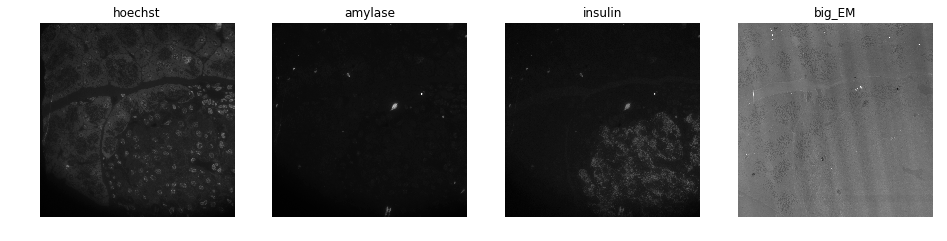

In [207]:
# Gather image tiles
sample_images = {}
for stack, tile_fn in sample_tile_fns.items():
    tif = TiffFile(tile_fn.as_posix())
    sample_images[stack] = tif.pages[0].asarray()
    
# Make figure
fig, axes = plt.subplots(ncols=len(channel_map), figsize=(16, 6))
for stack, ax in zip(channel_map.values(), axes.flat):
    ax.imshow(sample_images[stack], cmap='Greys_r')
    ax.set_title(stack)
    ax.axis('off')

#### Preview tiles with enhanced contrast

In [208]:
def get_intensity_range(img, outliers):
    """
    Find the intensity range fitting best an image based on the histogram and the specified outliers.
    
    Parameters
    ----------
    img : (M, N[, C]) ndarray
        Input image
    outliers : float
        Ratio of outliers to discard (on both sides)
        Must be within range (0 < outliers < 0.5)
        0 ----> discards no value
        0.5 --> discards every value (and so returns median)
        
    Returns
    -------
    rng : tuple
        Min and max values
    
    Notes
    -----
    Combination of `odemis.util.histogram` and `odemis.util.findOptimalRange`
    """
    # Get histogram and histogram edges
    idt = np.iinfo(img.dtype)
    irange = (idt.min, idt.max)
    length = irange[1] - irange[0] + 1
    hist = np.bincount(img.flat, minlength=length)
    edges = (0, hist.size - 1)
    
    if outliers == 0:
        inz = np.flatnonzero(hist)
        idxrng = inz[0], inz[-1]
    
    else:
        outliers /= 100
        cum_hist = hist.cumsum()
        nval = cum_hist[-1]
        
        # Remove 0 pixels from histogram if >0.1% and no pixels have value 1
        if hist[1] == 0 and cum_hist[0] / nval > 0.001:
            cum_hist -= cum_hist[0]
            nval = cum_hist[-1]
            
        oval = int(round(outliers * nval))
        lowv, highv = oval, nval - oval
        
        lowi = np.searchsorted(cum_hist, lowv, side='right')
        if hist[lowi] == lowv:
            lowi += 1
        highi = np.searchsorted(cum_hist, highv, side='left')
        
        idxrng = lowi, highi
    
    a = edges[0]
    b = (edges[1] - edges[0]) / (hist.size - 1)
    rng = (a + b * idxrng[0], a + b * idxrng[1])
    return rng

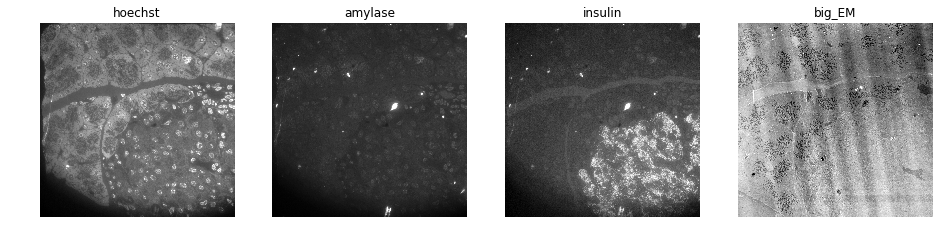

In [209]:
# Gather image tiles
sample_images = {}
for stack, tile_fn in sample_tile_fns.items():
    tif = TiffFile(tile_fn.as_posix())
    img = tif.pages[0].asarray()
    rng = get_intensity_range(img, 0.1)
    sample_images[stack] = np.clip(img, rng[0], rng[-1])
    
# Make figure
fig, axes = plt.subplots(ncols=len(channel_map), figsize=(16, 6))
for stack, ax in zip(channel_map.values(), axes.flat):
    ax.imshow(sample_images[stack], cmap='Greys_r')
    ax.set_title(stack)
    ax.axis('off')